# **Kernel SHAP**

## **Imports**

In [1]:
!pip install shap==0.39

     |████████████████████████████████| 358kB 6.2MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491644 sha256=fc1d5370981a2bb30accf17b5c5449f23484ab304d5a0b0c68d65d6c15ca5a04
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
import sklearn
import shap
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

## **Dataset**

We will use the iris dataset provided with SHAP to illustrate SHAP KernelExplainer.

Independent Variables:

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

Target Classes: 0: setosa 1: versicolor 2: virginica

In [3]:
# IRIS Dataset target classes:
# 0: setosa
# 1: versicolor
# 2: virginica
# train a SVM classifier
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
print(f'Training set size - X_train: {X_train.shape}, Y_train: {Y_train.shape}')
print(f'Test set size - X_test: {X_train.shape}, Y_train: {Y_test.shape}')

Training set size - X_train: (120, 4), Y_train: (120,)
Test set size - X_test: (120, 4), Y_train: (30,)


## **Training a classifier and explainer**

In [4]:
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

We will use SHAP KernelExplainer to explain the SVM model.

In [5]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model=svm.predict_proba, data=X_train, link="logit")

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Arguments of KernelExplainer() function:
- **model**: The model to be explained. The output of the model can be a vector of size n_samples or a matrix of size [n_samples x n_output] (for a classification model).
- **data**: Background dataset to generate the perturbed dataset required for training surrogate models. We simulate “missing” (‘0’s in zᵢ) by replacing the feature with the values it takes in the background dataset. So if the background dataset is a simple sample of all zeros, then we would approximate a feature being missing by setting it to zero. For small problems this background dataset can be the whole training set, but for larger problems consider using a single reference value or using the kmeans function to summarize the dataset.
- **link**: A function to connect feature contribution values to the model output. For a classification model, we generally explain the logit of the predicted probability as a sum of feature contributions. Hence, if the output of the “model” (the first argument) is a probability, we set link = “logit” to get the feature contributions in logit form.

Next, we compute the SHAP values as below:

In [6]:
shap_values = explainer.shap_values(X=X_test, nsamples=100, l1_reg="num_features(4)")

In [7]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (30, 4)


Arguments of explainer.shap_values() function:
- **X**: Dataset on which to explain the model output.
- **nsamples**: No. of samples to draw to build the surrogate model for explaining each prediction.
- **l1_reg**: The l1 regularization to use for selecting features to explain the model prediction. Possible values are: “num_features(<int>)”-Selects a fixed number of features to explain the model prediction; “aic”/”bic”-Uses AIC/BIC rules for regularization; <float>-Sets the alpha parameter for sklearn.linear_model.lasso; “auto”-Uses AIC when less than 20% of possible sample space is enumerated, otherwise uses no regularization.
For classification problems, explainer.shap_values() return a list of size n_classes (number of classes). For a binary classification model n_classes=2 (negative & positive class). Each object of this list is an array of size [n_samples, n_features] and corresponds to the SHAP values for the respective class. For regression models, we get a single set of shap values of size [n_samples, n_features]. Here, we have a 3-class classification problem, hence we get a list of length 3.

## **Explaining a single prediction**

Let’s explain the prediction for the first item in the testset.

In [8]:
# plot the SHAP values for the Setosa output of the first instance
print(f'Prediction for 1st sample in X_test: {svm.predict_proba(X_test.iloc[[0], :])[0]}')
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

Prediction for 1st sample in X_test: [0.0092534  0.03308766 0.95765894]


In [9]:
# plot the SHAP values for the Versicolor output of the first instance
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:], link="logit")

In [10]:
# plot the SHAP values for the Virginica output of the first instance
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], X_test.iloc[0,:], link="logit")

link=”logit” argument converts the logit values to probability. Each plot displays the base probability value for the respective class over the training dataset. Blue color indicates that the feature decreased the probability and the red color indicates that the feature value increased the probability.

## **Explaining the Prediction for all 30 samples in Test set**

If we take the above plot for any one class for each sample, rotate them 90 degrees and stack them side-by-side, we can explain the predictions for multiple samples in a single plot (note that the samples are ordered by similarity):


In [11]:
## Setosa output
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [12]:
## Versicolor output
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

In [13]:
## Virginica output
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2], X_test)

## **SHAP Summary Plots**

shap.summary_plot() can plot the mean shap values for each class if provided with a list of shap values (the output of explainer.shap_values() for a classification problem) as below:

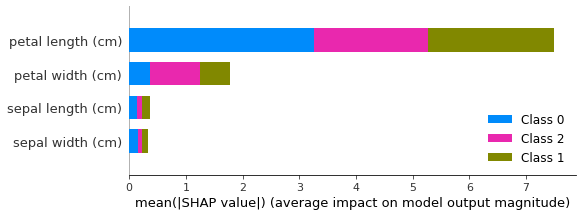

In [14]:
shap.summary_plot(shap_values, X_test)

The above plot indicates that petal length (cm) had the greatest influence on the predictions for all 3 classes followed by petal width (cm).
If provided with a single set of SHAP values (shap values for a single class for a classification problem or shap values for a regression problem), shap.summary_plot() creates a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output. Features are sorted by the sum of the SHAP value magnitudes across all samples.

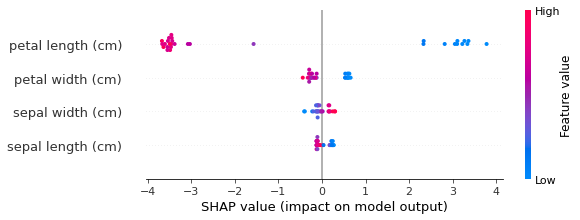

In [15]:
## Setosa output
shap.summary_plot(shap_values[0], X_test)

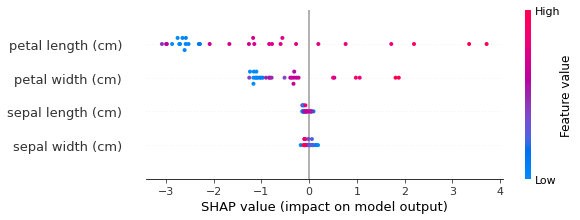

In [16]:
## Virginica output
shap.summary_plot(shap_values[2], X_test)

For Setosa output, we see that the low values of petal length (cm) (indicated by blue colored dots) increases the probability that the sample is classified as Setosa (high shap values).

## **SHAP Dependence Plots**

SHAP Depencence plots reveal interaction effects.


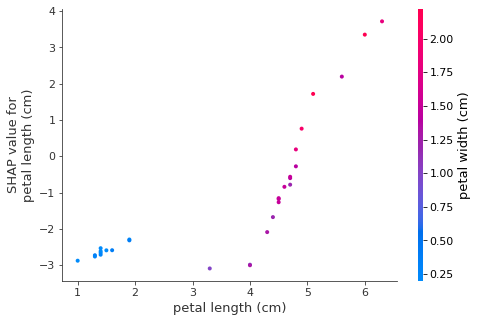

In [17]:
## Virginica output
shap.dependence_plot("petal length (cm)", shap_values[2], X_test)

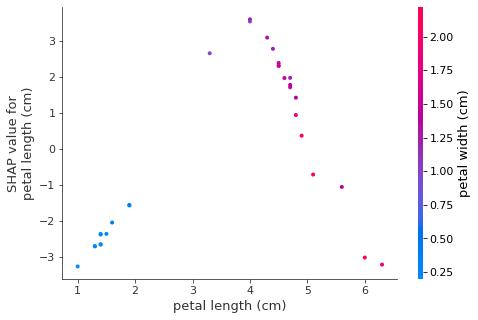

In [18]:
## Versicolor output
shap.dependence_plot("petal length (cm)", shap_values[1], X_test)

The Versicolor output depicts the interaction between petal length (cm) and petal width (cm).

## **Linear Regression**

In [19]:
%%capture
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

Input variables:
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):
12. quality (score between 0 and 10)

In [20]:
wine_df = pd.read_csv('winequality-red.csv', sep=';')
X_wine, Y_wine = wine_df.drop('quality', axis=1), wine_df['quality']

we standardize the data with `StandardScaler`.

In [21]:
X_wine_scaled = sklearn.preprocessing.StandardScaler().fit_transform(X_wine)
X_wine_scaled = pd.DataFrame(X_wine_scaled, columns=X_wine.columns)

Dataset split

In [22]:
X_wine_train, X_wine_test, Y_wine_train, Y_wine_test = train_test_split(X_wine_scaled, Y_wine, test_size=0.2, random_state=0)
X_wine_test_100 = shap.sample(X_wine_test, 100)

In [23]:
X_wine_train.shape, X_wine_test_100.shape

((1279, 11), (100, 11))

### Train a Suport Vector Regressor

In [24]:
model = sklearn.svm.SVR(C=1.0, epsilon=.2)
model.fit(X_wine_train, Y_wine_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

and predict the error for the dataset

In [25]:
predictions = model.predict(X_wine_test)
error = sklearn.metrics.mean_squared_error(Y_wine_test, predictions)
print(f"model trained with {error:.2f} MSE error")

model trained with 0.37 MSE error


### Train the KernelExplainer

In [26]:
explainer = shap.KernelExplainer(model=model.predict, data=shap.sample(X_wine_train, 100))
shap_values = explainer.shap_values(X=X_wine_test_100, nsamples=100)

### Force Plot

In [27]:
print(f'Prediction for 1st sample in X_wine_test: {model.predict(X_wine_test_100.iloc[[0], :])[0]}')
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_wine_test_100.iloc[0,:])

Prediction for 1st sample in X_wine_test: 5.014080889172155


### Explaining the Prediction for all samples in Test set

In [28]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_wine_test_100)

### SHAP Summary Plot

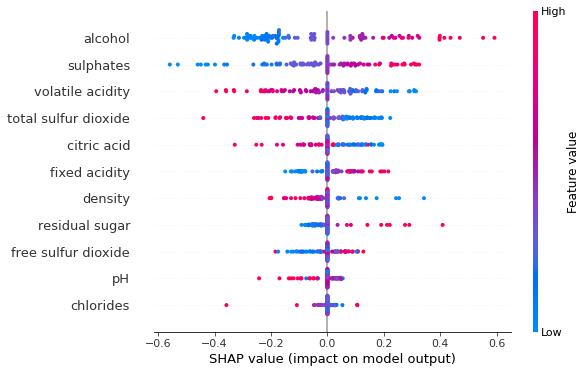

In [29]:
shap.summary_plot(shap_values, X_wine_test_100)

# **END**